In [1]:
import tensorflow as tf 
import os 
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.regularizers import l1
from keras.layers.core import Activation, Dense
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from scipy.stats import gaussian_kde

In [2]:
# Avoid OOM errors by setting GPU Memory Comsumption Growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
direct_p = ('/Users/abelcouto/Documents/Dissertation/sample/Gray_Images')

print(os.listdir(direct_p))

['.DS_Store', 'Findings', 'No_Findings']


In [4]:
#Get data from directory, pipeline

data_pipe = tf.keras.utils.image_dataset_from_directory('Gray_Images', image_size=(600, 600),color_mode="grayscale", batch_size=65,class_names = ['Findings', 'No_Findings'])

Found 5606 files belonging to 2 classes.
Metal device set to: Apple M1 Pro


2022-12-21 16:31:59.014197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-21 16:31:59.014344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:

data_iterator = data_pipe.as_numpy_iterator()

print (data_iterator)

In [6]:
batch = data_iterator.next()

print((batch[0].shape))

2022-12-21 16:31:59.090163: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(65, 600, 600, 1)


In [7]:
#Get image labels
print(batch[1])

[1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1
 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1]


In [8]:

data_pipe = data_pipe.map(lambda x,y: (x/255, y))

In [9]:
scaled_iterator = data_pipe.as_numpy_iterator()

In [10]:
batch= scaled_iterator.next()
print(batch[0].max())

1.0


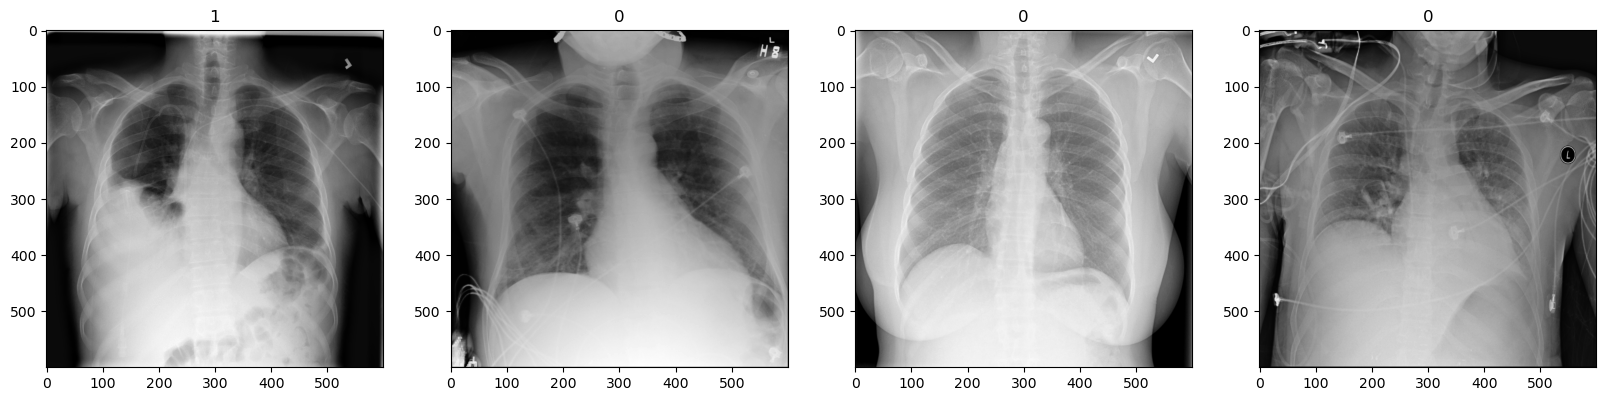

In [11]:

fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    
    ax[idx].imshow(img,cmap='gray')
    ax[idx].title.set_text(batch[1][idx])



In [12]:
print(len(data_pipe))

87


In [13]:
# Set parameters to divide our data sample
train_s = int(len(data_pipe)*.7)
val_s = int(len(data_pipe)*.2)+1
test_s = int(len(data_pipe)*.1)+1

In [14]:
print(test_s+train_s+val_s)

87


In [15]:
#Get data for train, val, test

train = data_pipe.take(train_s)
val = data_pipe.skip(train_s).take(val_s)
test = data_pipe.skip(train_s + val_s).take(test_s)

In [16]:
# Create Model 

model = Sequential()

In [17]:
model.add(Conv2D(8, (3,3),(2, 2), activation='relu', input_shape=(600,600,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(16, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

#model.add(Conv2D(32, (3,3), (2, 2), activation = 'relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

model.add(Conv2D(8, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())

model.add(Dense(2, activation ='linear', activity_regularizer=l1(0.001)))
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))

In [18]:
num_epochs = 25
num_train_steps = train_s * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=0.01,
    end_learning_rate=0.00001,
    decay_steps=num_train_steps
)



opt = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
model.compile(optimizer = opt,loss= tf.losses.BinaryCrossentropy(),metrics= ['accuracy',tf.keras.metrics.Precision(),
                                                                     tf.keras.metrics.Recall()
                                                                     ])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 8)       80        
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 149, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 74, 74, 16)       6

In [20]:
logdir = 'logs'

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [22]:
hist = model.fit(train, epochs = 50, validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/50


2022-12-21 16:32:02.182803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.5372 - precision: 0.5458 - recall: 0.9185

2022-12-21 16:32:12.206064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 19s 276ms/step - loss: 0.7120 - accuracy: 0.5372 - precision: 0.5458 - recall: 0.9185 - val_loss: 0.7016 - val_accuracy: 0.5316 - val_precision: 0.5321 - val_recall: 0.9984
Epoch 2/50
60/60 [==============================] - 17s 278ms/step - loss: 0.6912 - accuracy: 0.5813 - precision: 0.5779 - recall: 0.8814 - val_loss: 0.6876 - val_accuracy: 0.5368 - val_precision: 0.5329 - val_recall: 0.9626
Epoch 3/50
60/60 [==============================] - 17s 271ms/step - loss: 0.6761 - accuracy: 0.6126 - precision: 0.6123 - recall: 0.7888 - val_loss: 0.6699 - val_accuracy: 0.6162 - val_precision: 0.6401 - val_recall: 0.6869
Epoch 4/50
60/60 [==============================] - 17s 265ms/step - loss: 0.6638 - accuracy: 0.6269 - precision: 0.6233 - recall: 0.8073 - val_loss: 0.6748 - val_accuracy: 0.6043 - val_precision: 0.6472 - val_recall: 0.6056
Epoch 5/50
60/60 [==============================] - 17s 265ms/step - loss: 0.6584 - accuracy: 0.6413 - precisio

60/60 [==============================] - 19s 296ms/step - loss: 0.6199 - accuracy: 0.6574 - precision: 0.6660 - recall: 0.7584 - val_loss: 0.6414 - val_accuracy: 0.6470 - val_precision: 0.6541 - val_recall: 0.7397
Epoch 38/50
60/60 [==============================] - 19s 295ms/step - loss: 0.6216 - accuracy: 0.6641 - precision: 0.6656 - recall: 0.7783 - val_loss: 0.6518 - val_accuracy: 0.6308 - val_precision: 0.6431 - val_recall: 0.7257
Epoch 39/50
60/60 [==============================] - 20s 316ms/step - loss: 0.6268 - accuracy: 0.6567 - precision: 0.6627 - recall: 0.7621 - val_loss: 0.6536 - val_accuracy: 0.6316 - val_precision: 0.6299 - val_recall: 0.7444
Epoch 40/50
60/60 [==============================] - 20s 327ms/step - loss: 0.6101 - accuracy: 0.6703 - precision: 0.6742 - recall: 0.7765 - val_loss: 0.6502 - val_accuracy: 0.6419 - val_precision: 0.6404 - val_recall: 0.7444
Epoch 41/50
60/60 [==============================] - 21s 337ms/step - loss: 0.6186 - accuracy: 0.6710 - prec

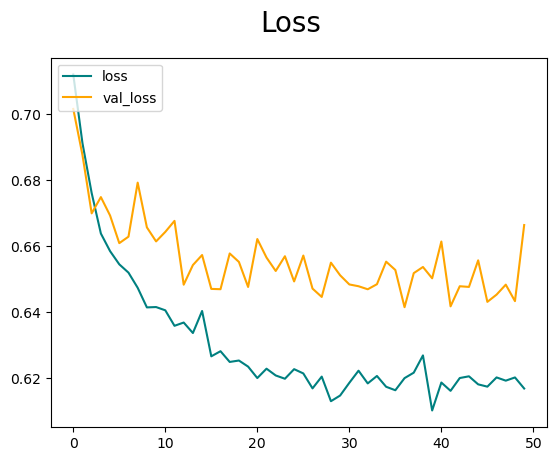

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color= 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color= 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc= 'upper left')
plt.show()

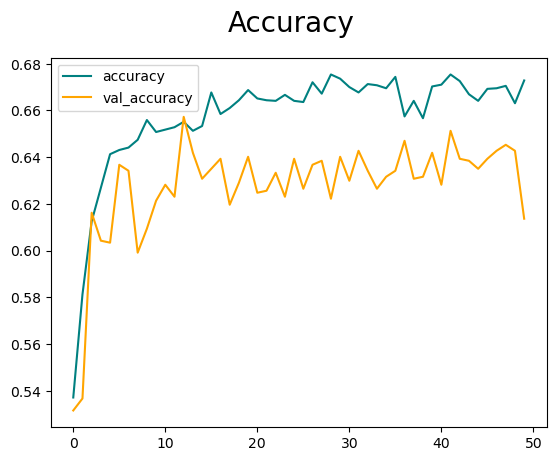

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color= 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color= 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc= 'upper left')
plt.show()

In [25]:
hist.history

{'loss': [0.7120241522789001,
  0.6911748647689819,
  0.6760529279708862,
  0.6637830138206482,
  0.6584417223930359,
  0.6544411182403564,
  0.6519185304641724,
  0.6473240852355957,
  0.641374945640564,
  0.6414781212806702,
  0.6404916644096375,
  0.6357919573783875,
  0.6367834806442261,
  0.6336050033569336,
  0.6402872204780579,
  0.6265376806259155,
  0.62808758020401,
  0.6248306632041931,
  0.6252620220184326,
  0.6234137415885925,
  0.6199436187744141,
  0.6227840185165405,
  0.6207298636436462,
  0.6197345852851868,
  0.6226400136947632,
  0.6213436722755432,
  0.6168123483657837,
  0.6203817129135132,
  0.6129226088523865,
  0.6146438717842102,
  0.6185044050216675,
  0.6221792697906494,
  0.6183193325996399,
  0.6205756068229675,
  0.6172953844070435,
  0.6162486672401428,
  0.6199221014976501,
  0.6215764880180359,
  0.6268118619918823,
  0.6101091504096985,
  0.6185861825942993,
  0.6160678863525391,
  0.6199518442153931,
  0.6204729080200195,
  0.6180340051651001,
  0.6

In [26]:
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [27]:
for batch in test.as_numpy_iterator():
    x,y = batch
    yhat = model.predict(x)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

3/3 [==============================] - 0s 41ms/step


2022-12-21 16:46:29.882826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 45ms/step


In [28]:
print(f'Precision: {prec.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision: 0.6029412150382996, Recall: 0.7454545497894287, Accuracy: 0.6175373196601868


In [31]:
F05 = (1.25 * 0.6029412150382996 * 0.7454545497894287) / (0.25 * 0.6029412150382996 + 0.7454545497894287)

In [32]:
print(F05)

0.6269113489540444
